In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
THRESHOLD: int = 98

#  3: Load local_hour_adjusted_variables

In [2]:
summary_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.05/research_results/summary'

# merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables.feather')
merged_feather_path = os.path.join(summary_dir, f'updated_local_hour_adjusted_variables_HW{THRESHOLD}.feather')

local_hour_adjusted_df = pd.read_feather(merged_feather_path)
local_hour_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6181728 entries, 0 to 6181727
Columns: 109 entries, time to hw_nohw_diff_SOILWATER_10CM
dtypes: bool(1), datetime64[ns](2), float32(96), float64(3), int32(4), object(3)
memory usage: 2.7+ GB


##  3.1: unique number of locations 



In [3]:
len(local_hour_adjusted_df['location_ID'].unique()) 

3648

In [4]:

# import pandas as pd
# import numpy as np
# import xarray as xr
# import os

# # Load the NetCDF file
# one_simu_result_monthly_file = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.1985-01.nc'
# ds = xr.open_dataset(one_simu_result_monthly_file)

# # Extract latitude and longitude values
# lat_values = ds['lat'].values
# lon_values = ds['lon'].values

# # Create a MultiIndex from the latitude and longitude values
# multi_index = pd.MultiIndex.from_product([lat_values, lon_values], names=['lat', 'lon'])

# # Create a DataFrame with the flattened index (location_ID)
# location_df = pd.DataFrame(index=multi_index).reset_index()
# location_df['location_ID'] = np.arange(len(location_df))

# # Merge the location_df with the local_hour_adjusted_df
# local_hour_adjusted_df = pd.merge(local_hour_adjusted_df, location_df, on=['lat', 'lon'], how='left')



##  3.2 compute average based on local hour

In [5]:
# os.environ["PROJ_LIB"] = "/home/jguo/anaconda3/envs/I2000/share/proj"
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Group by 'lat', 'lon', and 'local_hour', then calculate the mean for 'UHI_diff'
# Ensure grouped data is sorted by 'lat' and 'lon' before pivoting
var_diff_by_localhour = local_hour_adjusted_df.groupby(['lat', 'lon', 'local_hour'])[['UHI_diff', 'UWBI_diff']].mean().reset_index().sort_values(by=['lat', 'lon', 'local_hour'])

var_diff_by_localhour


,lat,lon,local_hour,UHI_diff,UWBI_diff
0,-55.130890,291.25,0,0.231274,0.095413
1,-55.130890,291.25,1,0.238729,0.100294
2,-55.130890,291.25,2,0.237159,0.102892
3,-55.130890,291.25,3,0.231386,0.103964
4,-55.130890,291.25,4,0.268107,0.109410
...,...,...,...,...,...
87547,70.209427,31.25,19,0.064341,-0.016423
87548,70.209427,31.25,20,0.062933,-0.020819
87549,70.209427,31.25,21,0.083317,-0.026059
87550,70.209427,31.25,22,0.094672,-0.014309


In [6]:
var_diff_by_localhour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87552 entries, 0 to 87551
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         87552 non-null  float32
 1   lon         87552 non-null  float32
 2   local_hour  87552 non-null  int32  
 3   UHI_diff    87552 non-null  float32
 4   UWBI_diff   87552 non-null  float32
dtypes: float32(4), int32(1)
memory usage: 1.7 MB


# 4: Plot and Explore

## 4.1: Plot the UHI_diff and UWBI by local hour

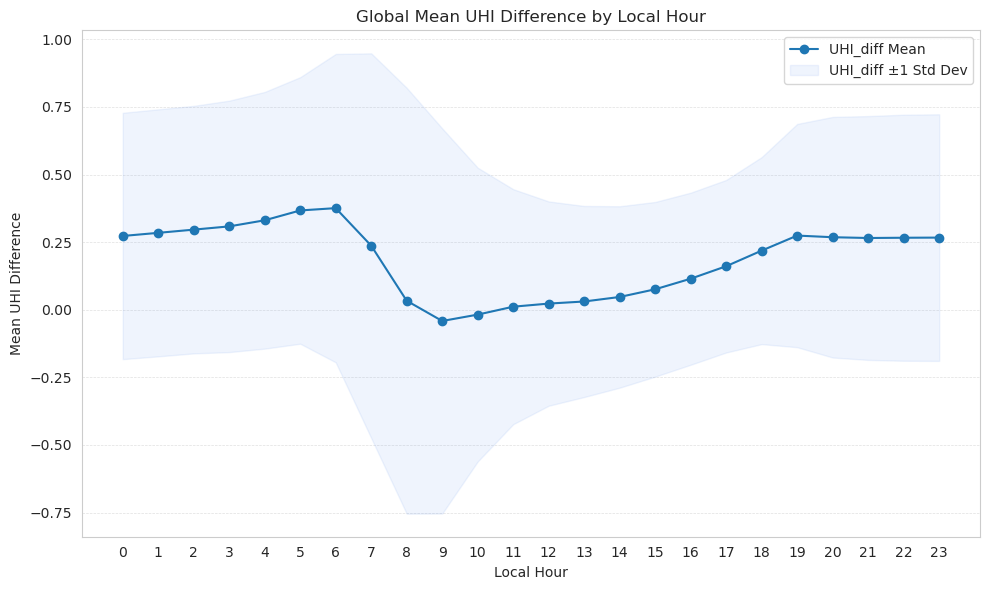

In [42]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'local_hour' and calculate the mean and standard deviation of 'UHI_diff'
grouped_df = local_hour_adjusted_df.groupby('local_hour')['UHI_diff'].agg(['mean', 'std'])

# Plotting
plt.figure(figsize=(10, 6))

# Plot UHI_diff mean
plt.plot(grouped_df.index, grouped_df['mean'], marker='o', label='UHI_diff Mean')

# Plot the standard deviation band
plt.fill_between(grouped_df.index, grouped_df['mean'] - grouped_df['std'], grouped_df['mean'] + grouped_df['std'], color='cornflowerblue', alpha=0.1, label='UHI_diff ±1 Std Dev')

plt.title('Global Mean UHI Difference by Local Hour')
plt.xlabel('Local Hour')
plt.ylabel('Mean UHI Difference')

# Correct approach: Set horizontal grid FIRST
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)  # Horizontal ON
plt.grid(False, axis='x')  # Vertical OFF

plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
"""


# Define the map drawing function for subplots
def draw_map_subplot(m, ax):
    m.drawcoastlines(linewidth=0.5, ax=ax)
    m.drawcountries(linewidth=0.5, ax=ax)
    m.fillcontinents(color='coral', lake_color='aqua', alpha=0.3, ax=ax)
    m.drawmapboundary(fill_color='aqua', ax=ax)
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10, ax=ax)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10, ax=ax)

# Find global min and max of UHI_diff
global_min = var_diff_by_localhour['UHI_diff'].min()
global_max = var_diff_by_localhour['UHI_diff'].max()

# Calculate the number of rows needed for the subplots
n_hours = len(var_diff_by_localhour['local_hour'].unique())
n_rows = (n_hours + 2) // 3  # Adding 2 to ensure rounding up if there's a remainder

# Create a figure to hold all subplots
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 6), constrained_layout=True)

# Iterate through each local_hour to create subplots
for i, hour in enumerate(var_diff_by_localhour['local_hour'].unique()):
    row, col = divmod(i, 3)
    ax = axs[row, col] if n_rows > 1 else axs[col]  # Adjust for the case of a single row

    # Setup the Basemap
    m = Basemap(projection='cyl', resolution='l', lat_0=0, lon_0=0, ax=ax)

    draw_map_subplot(m, ax)

    # Filter data for the current hour
    df_hour = var_diff_by_localhour[var_diff_by_localhour['local_hour'] == hour]

    # Scatter UHI_diff data
    x, y = m(df_hour['lon'].values, df_hour['lat'].values)
    # Set vmin and vmax to the global min/max values
    sc = m.scatter(x, y, c=df_hour['UHI_diff'], vmin=global_min, vmax=global_max, cmap='hot', marker='o', edgecolor='none', alpha=0.75, ax=ax)

    ax.set_title(f'UHI Difference Map at Local Hour {hour}')

    # Add color bar to each subplot
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label='UHI_diff')

plt.show()

"""


"\n\n\n# Define the map drawing function for subplots\ndef draw_map_subplot(m, ax):\n    m.drawcoastlines(linewidth=0.5, ax=ax)\n    m.drawcountries(linewidth=0.5, ax=ax)\n    m.fillcontinents(color='coral', lake_color='aqua', alpha=0.3, ax=ax)\n    m.drawmapboundary(fill_color='aqua', ax=ax)\n    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10, ax=ax)\n    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10, ax=ax)\n\n# Find global min and max of UHI_diff\nglobal_min = var_diff_by_localhour['UHI_diff'].min()\nglobal_max = var_diff_by_localhour['UHI_diff'].max()\n\n# Calculate the number of rows needed for the subplots\nn_hours = len(var_diff_by_localhour['local_hour'].unique())\nn_rows = (n_hours + 2) // 3  # Adding 2 to ensure rounding up if there's a remainder\n\n# Create a figure to hold all subplots\nfig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 6), constrained_layout=True)\n\n# Iterate through each local_hour to cre

I have some understanding about UHI:
1. Diurnal Cycle of Solar Radiation: During the daytime, solar radiation is the primary source of heat for both urban and rural areas. However, urban surfaces, with their lower albedo and higher heat capacity, tend to absorb and store more solar radiation than rural surfaces. This leads to a smaller UHI effect during the day. At night, the absence of solar radiation allows the stored heat in urban areas to be gradually released, resulting in a stronger UHI effect at night.
2. Boundary Layer Dynamics: The atmospheric boundary layer, the layer of air closest to the Earth's surface, plays a crucial role in heat dissipation. During the day, the boundary layer is typically deeper and more turbulent, promoting greater mixing and heat exchange between the surface and the atmosphere. This can help to mitigate the UHI effect. At night, the boundary layer becomes shallower and more stable, trapping heat near the surface and intensifying the UHI effect.

I need to better understand why the synergy is also showing a diurnal cycle.

##  4.2: Koppen Geiger Climate Analysis

###  4.2.1: load the koppen geiger map and legend

In [9]:

import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
ds_koppen_map = xr.open_dataset('/home/jguo/other_projects/1991_2020/koppen_geiger_0p5.nc')
#ds_koppen_map.kg_class.min()

# Load the Koppen Geiger Legend Excel file
kg_legend = pd.read_excel('/home/jguo/research/hw_global/Data/KoppenGeigerLegend.xlsx', engine='openpyxl')
kg_legend

,ID,KGShort,KGClass,KGMajorClass,Color
0,1,Af,"Tropical, rainforest",Tropical,[0 0 255]
1,2,Am,"Tropical, monsoon",Tropical,[0 120 255]
2,3,Aw,"Tropical, savannah",Tropical,[70 170 250]
3,4,BWh,"Arid, desert, hot",Arid,[255 0 0]
4,5,BWk,"Arid, desert, cold",Arid,[255 150 150]
5,6,BSh,"Arid, steppe, hot",Arid,[245 165 0]
6,7,BSk,"Arid, steppe, cold",Arid,[255 220 100]
7,8,Csa,"Temperate, dry summer, hot summer",Temperate,[255 255 0]
8,9,Csb,"Temperate, dry summer, warm summer",Temperate,[200 200 0]
9,10,Csc,"Temperate, dry summer, cold summer",Temperate,[150 150 0]


###  4.2.2: Find the nearest Koppen Geiger class for each grid cell

In [10]:

# Convert latitudes and longitudes from the NetCDF dataset to numpy arrays
latitudes = ds_koppen_map['lat'].values
longitudes = ds_koppen_map['lon'].values

# Flatten the latitudes, longitudes, and kg_class for easier manipulation
lat_flat = np.repeat(latitudes, len(longitudes))
lon_flat = np.tile(longitudes, len(latitudes))
kg_class_flat = ds_koppen_map['kg_class'].values.flatten()

# Filter out the zero kg_class values
non_zero_indices = kg_class_flat > 0
lat_flat_non_zero = lat_flat[non_zero_indices]
lon_flat_non_zero = lon_flat[non_zero_indices]
kg_class_flat_non_zero = kg_class_flat[non_zero_indices]

# Function to find the nearest non-zero kg_class for given lat and lon
def find_nearest_non_zero_kg_class(lat, lon):
    distances = np.sqrt((lat_flat_non_zero - lat)**2 + (lon_flat_non_zero - lon)**2)
    nearest_index = np.argmin(distances)
    return kg_class_flat_non_zero[nearest_index]

# Vectorize the function to apply it efficiently to arrays
vec_find_nearest_non_zero_kg_class = np.vectorize(find_nearest_non_zero_kg_class)

# Apply the vectorized function to each lat and lon in var_diff_by_localhour
var_diff_by_localhour['KG_ID'] = vec_find_nearest_non_zero_kg_class(var_diff_by_localhour['lat'].values, var_diff_by_localhour['lon'].values)
var_diff_by_localhour.head()

,lat,lon,local_hour,UHI_diff,UWBI_diff,KG_ID
0,-55.13089,291.25,0,0.231274,0.095413,29.0
1,-55.13089,291.25,1,0.238729,0.100294,29.0
2,-55.13089,291.25,2,0.237159,0.102892,29.0
3,-55.13089,291.25,3,0.231386,0.103964,29.0
4,-55.13089,291.25,4,0.268107,0.109410,29.0


###  4.2.3: Plot the UHI_diff by local hour for each Koppen Geiger class

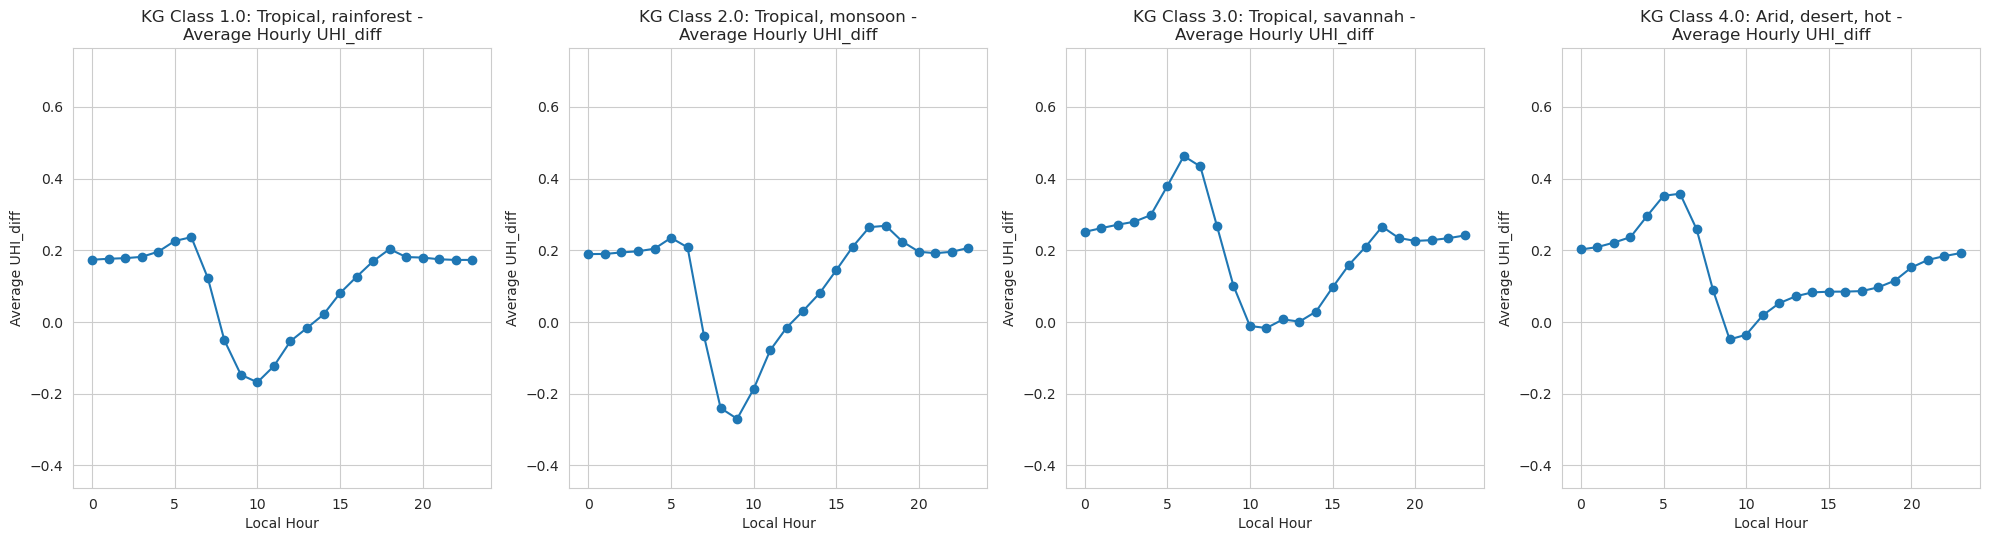

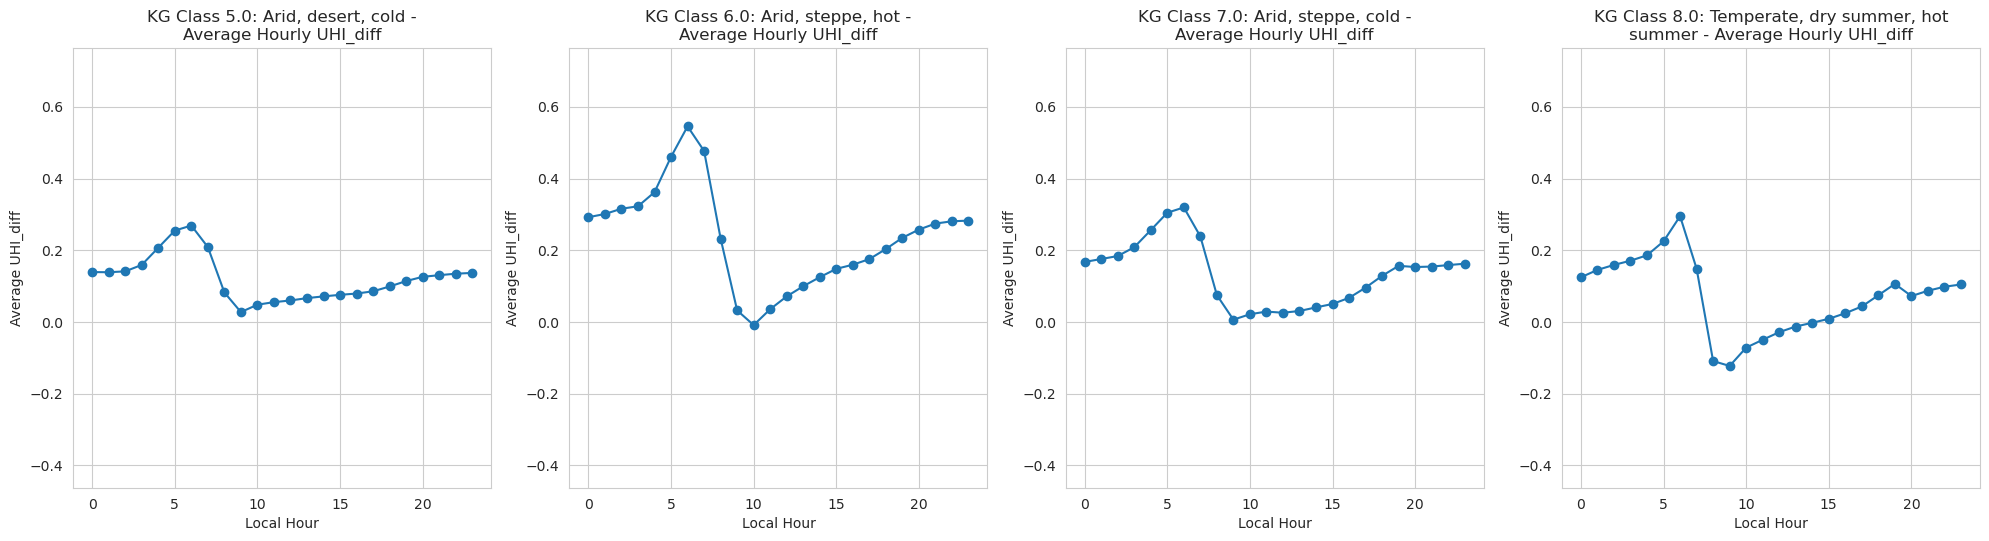

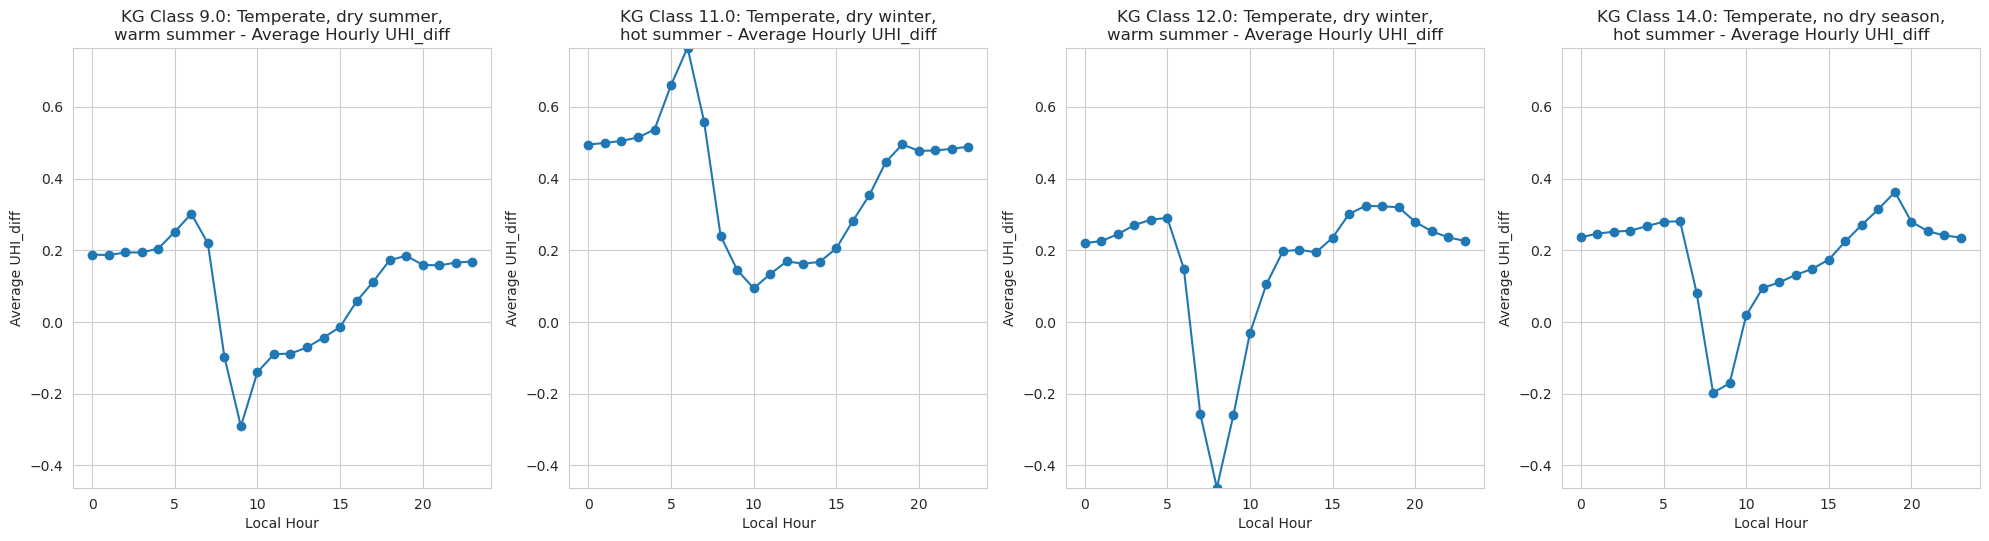

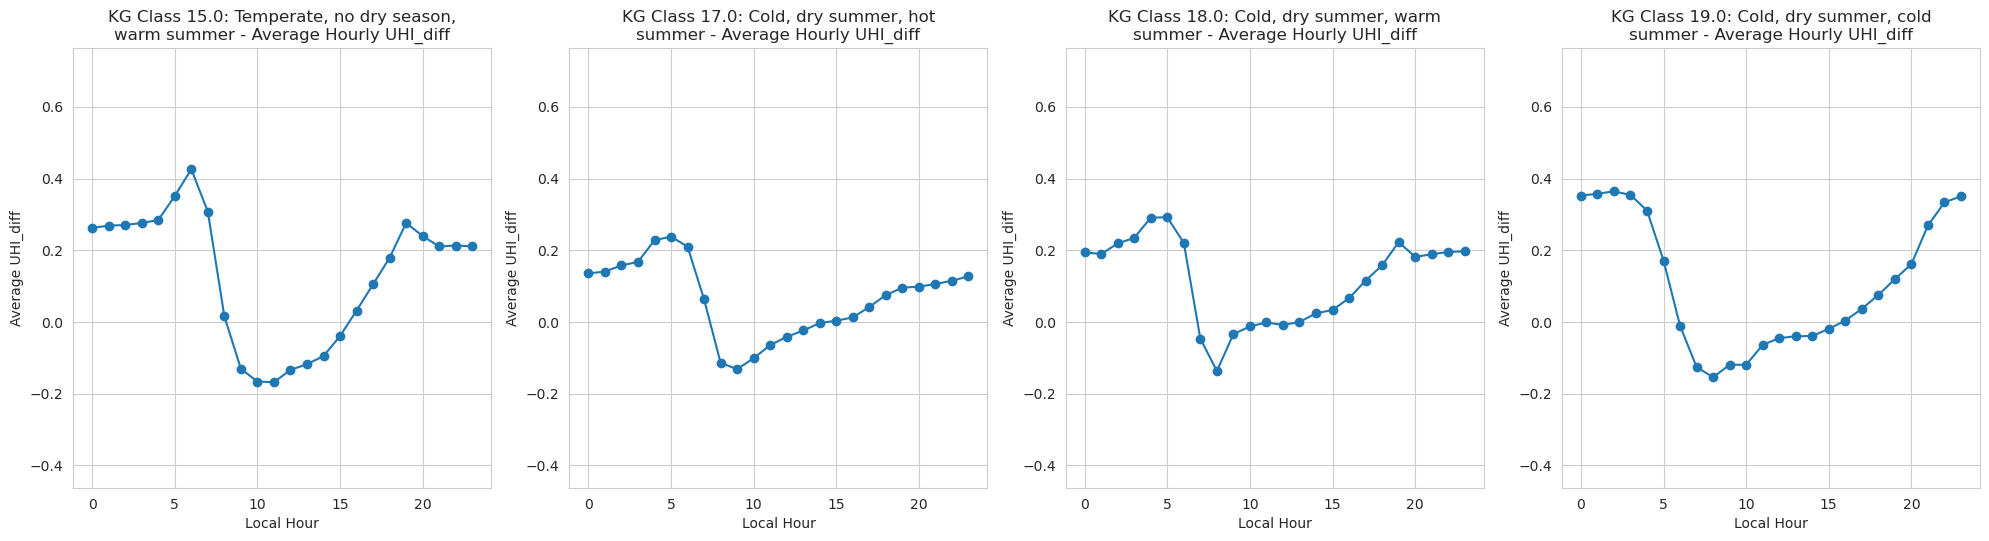

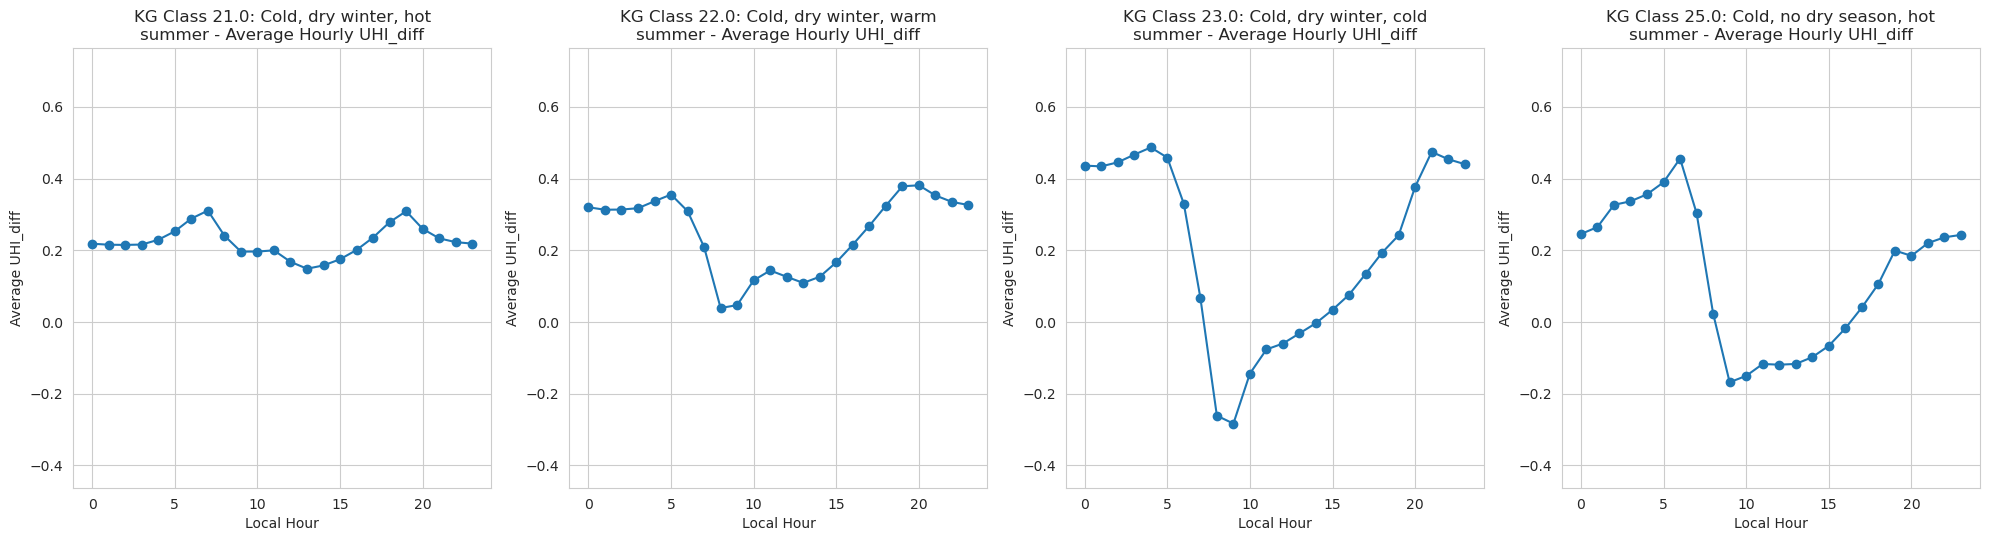

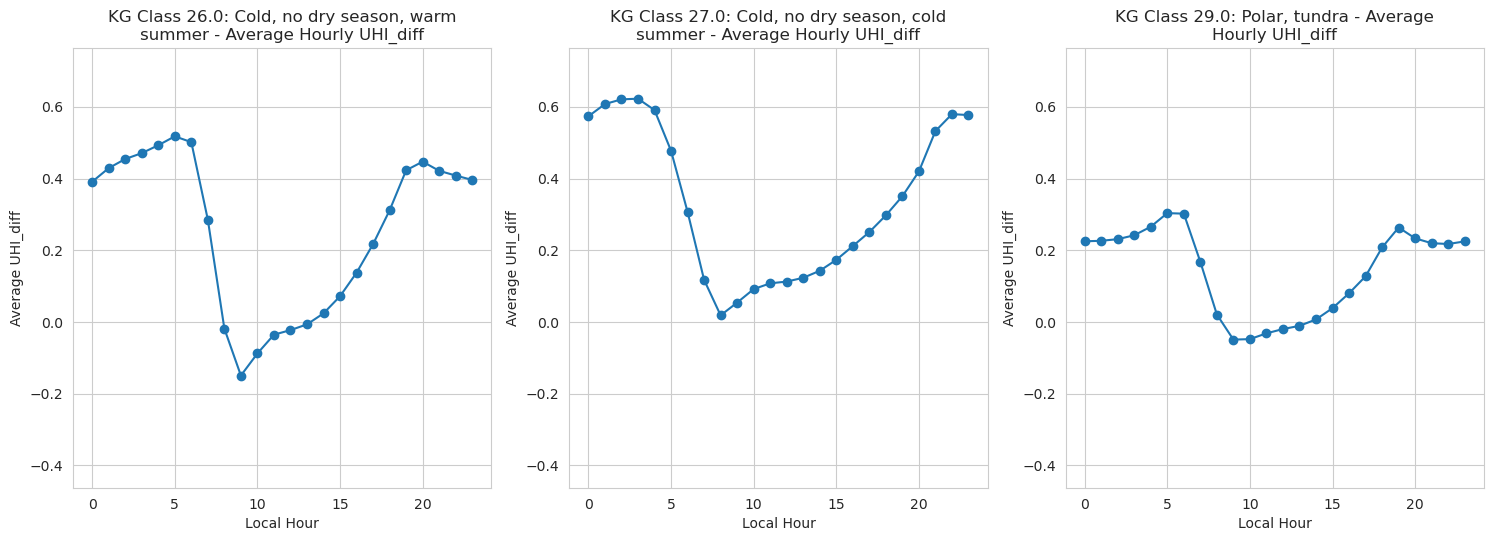

In [11]:

# Calculate average UHI_diff by local_hour for each KG class
avg_uhi_by_hour_and_kg = var_diff_by_localhour.groupby(['KG_ID', 'local_hour'])['UHI_diff'].mean().reset_index()
# Map KG classes to their descriptions
kg_map = dict(zip(kg_legend['ID'], kg_legend['KGClass']))
# Plotting
import textwrap

# Define the number of graphs you want in each row
graphs_per_row = 4  # You can change this number to your preference

# Find the global minimum and maximum UHI_diff values for consistent y-axis limits
global_min_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].min()
global_max_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].max()

# Unique KG IDs
unique_kg_ids = avg_uhi_by_hour_and_kg['KG_ID'].unique()

# Number of KG IDs
n_kg_ids = len(unique_kg_ids)

# Calculate the number of rows needed
n_rows = (n_kg_ids + graphs_per_row - 1) // graphs_per_row  # Ensures rounding up

# Loop through each KG ID
for i, kg_id in enumerate(unique_kg_ids):
    # Create a new figure at the start and after every 'graphs_per_row' plots
    if i % graphs_per_row == 0:
        plt.figure(figsize=(5 * graphs_per_row, 5 * n_rows))  # Adjust figure size as needed
    # Select the subplot position
    plt.subplot(n_rows, graphs_per_row, i % graphs_per_row + 1)

    # Extract the subset of data for the current KG ID
    subset = avg_uhi_by_hour_and_kg[avg_uhi_by_hour_and_kg['KG_ID'] == kg_id]

    # Plot the data
    plt.plot(subset['local_hour'], subset['UHI_diff'], marker='o')

    # Wrap the title text
    title_text = f'KG Class {kg_id}: {kg_map.get(kg_id, "Unknown")} - Average Hourly UHI_diff'
    wrapped_title = textwrap.fill(title_text, width=40)  # Adjust 'width' as needed

    plt.title(wrapped_title)
    plt.xlabel('Local Hour')
    plt.ylabel('Average UHI_diff')
    plt.grid(True)

    # Set the same y-axis limits for all plots
    plt.ylim(global_min_uhi, global_max_uhi)

    # Show the figure after every 'graphs_per_row' plots or on the last plot
    if (i % graphs_per_row == graphs_per_row - 1) or (i == n_kg_ids - 1):
        plt.tight_layout()
        plt.show()






###  4.2.4: Main group analysis: Aggregate data based on the main group only.

In [12]:
# The kg_legend data frame has a KGClass column, which has values for KG classification main group and subgroup, separated by a comma.
# Extract main group from KGClass
kg_legend['KGMainGroup'] = kg_legend['KGClass'].apply(lambda x: x.split(',')[0].strip())

# Map KG IDs to their main groups
kg_main_group_map = dict(zip(kg_legend['ID'], kg_legend['KGMainGroup']))
kg_main_group_map

{1: 'Tropical',
 2: 'Tropical',
 3: 'Tropical',
 4: 'Arid',
 5: 'Arid',
 6: 'Arid',
 7: 'Arid',
 8: 'Temperate',
 9: 'Temperate',
 10: 'Temperate',
 11: 'Temperate',
 12: 'Temperate',
 13: 'Temperate',
 14: 'Temperate',
 15: 'Temperate',
 16: 'Temperate',
 17: 'Cold',
 18: 'Cold',
 19: 'Cold',
 20: 'Cold',
 21: 'Cold',
 22: 'Cold',
 23: 'Cold',
 24: 'Cold',
 25: 'Cold',
 26: 'Cold',
 27: 'Cold',
 28: 'Cold',
 29: 'Polar',
 30: 'Polar'}

In [13]:
set(kg_main_group_map.values())

{'Arid', 'Cold', 'Polar', 'Temperate', 'Tropical'}

In [14]:
# Extract main group from KGClass
kg_legend['KGMainGroup'] = kg_legend['KGClass'].apply(lambda x: x.split(',')[0].strip())

# Map KG IDs to their main groups
kg_main_group_map = dict(zip(kg_legend['ID'], kg_legend['KGMainGroup']))

# Create a dictionary to map main group values to their minimum IDs
main_group_min_id = {}
for kg_id, main_group in kg_main_group_map.items():
    if main_group not in main_group_min_id:
        main_group_min_id[main_group] = kg_id
    else:
        main_group_min_id[main_group] = min(main_group_min_id[main_group], kg_id)

# Get the unique main group values sorted by their minimum IDs
sorted_main_groups = sorted(set(kg_main_group_map.values()), key=lambda x: main_group_min_id[x])

# Add main group to var_diff_by_localhour
var_diff_by_localhour['KGMainGroup'] = var_diff_by_localhour['KG_ID'].map(kg_main_group_map)

# Calculate average UHI_diff and UWBI_diff by local_hour for each KG main group
avg_diff_by_hour_and_main_group = var_diff_by_localhour.groupby(['KGMainGroup', 'local_hour'])[['UHI_diff', 'UWBI_diff']].mean().reset_index()

# Find the global minimum and maximum values for UHI_diff and UWBI_diff
min_uhi_diff = avg_diff_by_hour_and_main_group['UHI_diff'].min()
max_uhi_diff = avg_diff_by_hour_and_main_group['UHI_diff'].max()
min_UWBI_diff = avg_diff_by_hour_and_main_group['UWBI_diff'].min()
max_UWBI_diff = avg_diff_by_hour_and_main_group['UWBI_diff'].max()

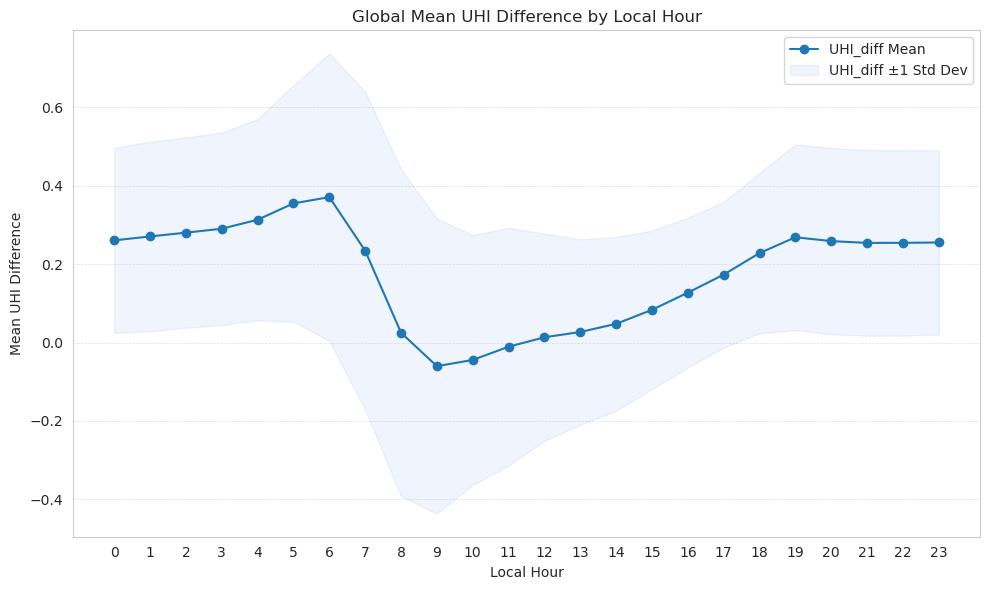

In [44]:

# Determine the number of rows needed for subplots
n_rows = (len(sorted_main_groups) + 3) // 4

# Create subplots
fig, axs = plt.subplots(n_rows, 4, figsize=(20, 6*n_rows), squeeze=False)

# Plotting
for i, main_group in enumerate(sorted_main_groups):
    row = i // 4
    col = i % 4

    subset = avg_diff_by_hour_and_main_group[avg_diff_by_hour_and_main_group['KGMainGroup'] == main_group]

    axs[row, col].plot(subset['local_hour'], subset['UHI_diff'], marker='o', label='UHI_diff')
    # axs[row, col].plot(subset['local_hour'], subset['UWBI_diff'], marker='s', label='UWBI_diff')

    # Create font dictionaries for the title
    title_font = {'size': 14, 'weight': 'normal'}
    main_group_font = {'size': 16, 'weight': 'bold'}

    # Create the title with the main group in bold and bigger font
    axs[row, col].set_title(f'KG Main Group:', fontdict=title_font)
    axs[row, col].text(0.5, 1.05, main_group, fontdict=main_group_font, transform=axs[row, col].transAxes, ha='center', va='bottom')

    axs[row, col].set_xlabel('Local Hour')
    axs[row, col].set_ylabel('Average Difference')
    axs[row, col].grid(True)
    axs[row, col].legend()

    # Set the same y-axis limits for all subplots
    # axs[row, col].set_ylim(min(min_uhi_diff, min_UWBI_diff), max(max_uhi_diff, max_UWBI_diff))
    axs[row, col].set_ylim(-0.75, 0.75)

# Remove any unused subplots
for i in range(len(sorted_main_groups), n_rows * 4):
    row = i // 4
    col = i % 4
    fig.delaxes(axs[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top spacing
plt.suptitle('Average Hourly UHI_diff and UWBI_diff by KG Main Group', size=20, weight='bold', y=0.99)  # Add an overall title

plt.show()

# 5. Next Steps: Statistical Analysis and Interpretation#3

##  5.0: some food for thoughts:

Green space ratio and road area ratio consistently emerged as the most influential factors for both summer and winter seasons. 
This suggests that the extent of vegetation and paved surfaces in an area are strong predictors of UHI effects year-round in Seoul.

Water area ratio had a higher importance in the summer compared to winter. This could be due to the cooling effect of water bodies being more pronounced in warmer months.
Surface albedo, which affects the reflectivity of surfaces, also showed seasonal differences in importance, with a higher influence in winter than summer.

In [16]:
import xarray as xr
import numpy as np
import pandas as pd


#  Understand land surface data
##  1.  Load the landsurface data
fsurdat: str = "/home/jguo/projects/cesm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc"
# Load the dataset
ds_sur = xr.open_mfdataset(fsurdat)
ds_sur

<xarray.Dataset> Size: 493MB
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 8B 15 16
  * time                     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 4B ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 221kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 4MB dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 4MB dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 4MB dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    FMAX                     (lsmlat, lsmlon) float64 442kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 442kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 442kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_GRAZING            (lsmlat, lsmlon) float64 442kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 885kB dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 7MB dask.array<chunksize=(15, 192, 288), meta=np.ndarray>
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 885kB dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

In [17]:

##  2. Assign coordinate value to be actual lat and lon degree not the index
print(ds_sur.coords)
print(ds_sur.dims)
# Extract a column of unique latitudes and a row of unique longitudes as raw arrays
# convert to float32 to match the hw temperature data later. this gave me a lot of trouble
unique_lats = ds_sur['LATIXY'].isel(lsmlon=0).data.astype('float32')  # Extracting the raw array for latitudes
unique_lons = ds_sur['LONGXY'].isel(lsmlat=0).data.astype('float32')  # Extracting the raw array for longitudes

# Assign these raw arrays as new coordinates (without specifying old dimensions)
ds_sur = ds_sur.assign_coords(lat=('lsmlat', unique_lats), lon=('lsmlon', unique_lons))

# Swap 'lsmlat' and 'lsmlon' dimensions with 'lat' and 'lon'
ds_sur = ds_sur.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

# Drop the original 'lsmlat' and 'lsmlon' dimensions if they are no longer needed
ds_sur = ds_sur.drop_vars(['lsmlat', 'lsmlon'], errors='ignore')


# Now, your DataArray or any variable extracted from ds_sur should have 1 dimensionional (1D) lat and lon coordinates
total_urban_pct = ds_sur['PCT_URBAN']  # Example variable
print(total_urban_pct)

# At this point, the dataset dimensions will be based on actual latitude and longitude values


##  3.  Determine which grid is Urban
# Access the PCT_URBAN variable
pct_urban = ds_sur['PCT_URBAN']
pct_urban

# Sum across the 'numurbl' dimension to get total urban coverage

# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')
print(total_urban_pct)
total_urban_pct

Coordinates:
  * natpft   (natpft) int32 60B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft      (cft) int32 8B 15 16
  * time     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
FrozenMappingWarningOnValuesAccess({'lsmlat': 192, 'lsmlon': 288, 'nlevsoi': 10, 'natpft': 15, 'cft': 2, 'time': 12, 'lsmpft': 17, 'numurbl': 3, 'numrad': 2, 'nlevurb': 5, 'nglcecp1': 11, 'nglcec': 10})
<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lat: 192, lon: 288)> Size: 1MB
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: numurbl
Attributes:
    long_name:  percent urban for each density type
    units:      unitless
<xarray.DataArray 'PCT_URBAN' (lat: 192, lon: 288)> Size: 442kB
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunk

<xarray.DataArray 'PCT_URBAN' (lat: 192, lon: 288)> Size: 442kB
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

## 5.1: Statistical Analysis: LHS UHI_diff or UWBI_diff. RHS KG_ID (major and sub categories), day and night (we are going to collapse the hours into day and night)

## 5.2: Try using UHI_hour on the LHS and perform similar analysis as above.  

## 5.3: Coastline analysis. (optional because Kopphen Geiger zones has in a way already capture the coastal effect to me) 

#   Miscalanous items

## group by north south hemisphere

In [18]:
var_diff_by_localhour.groupby(lambda x: (var_diff_by_localhour.loc[x, 'lat'] > 0, var_diff_by_localhour.loc[x, 'local_hour']))['UHI_diff'].mean()

(False, 0)     0.148993
(False, 1)     0.155333
(False, 2)     0.164298
(False, 3)     0.167536
(False, 4)     0.182200
(False, 5)     0.216013
(False, 6)     0.259071
(False, 7)     0.214792
(False, 8)     0.069506
(False, 9)    -0.052285
(False, 10)   -0.071671
(False, 11)   -0.075901
(False, 12)   -0.054776
(False, 13)   -0.037505
(False, 14)   -0.008293
(False, 15)    0.040150
(False, 16)    0.082347
(False, 17)    0.125550
(False, 18)    0.154859
(False, 19)    0.146851
(False, 20)    0.144459
(False, 21)    0.141900
(False, 22)    0.141766
(False, 23)    0.145181
(True, 0)      0.283340
(True, 1)      0.294096
(True, 2)      0.303867
(True, 3)      0.315256
(True, 4)      0.339917
(True, 5)      0.383254
(True, 6)      0.393617
(True, 7)      0.238169
(True, 8)      0.016065
(True, 9)     -0.061897
(True, 10)    -0.038829
(True, 11)     0.002534
(True, 12)     0.027288
(True, 13)     0.039949
(True, 14)     0.059097
(True, 15)     0.092252
(True, 16)     0.136377
(True, 17)     0